In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, GRU, Bidirectional, LSTM
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error
import keras

Using TensorFlow backend.


In [2]:
dataset = pd.read_csv('../input/historical_stock_prices.csv', index_col='date', parse_dates=['date'])

In [3]:
trainSet = dataset['2015':'2017'].sort_values(by=['ticker','date'])
testSet = dataset['2018':].sort_values(by=['ticker','date'])

In [4]:
trainSet.head()

,ticker,open,close,adj_close,low,high,volume
date,,,,,,,
2015-01-02,A,41.180000,40.560001,39.161114,40.369999,41.310001,1529200
2015-01-05,A,40.320000,39.799999,38.427319,39.700001,40.459999,2041800
2015-01-06,A,39.810001,39.180000,37.828701,39.020000,40.020000,2080600
2015-01-07,A,39.520000,39.700001,38.330769,39.290001,39.810001,3359700
2015-01-08,A,40.240002,40.889999,39.479725,40.180000,40.980000,2116300


In [5]:
symbols = trainSet.ticker.unique()

In [6]:
timesteps = 60
def make_samples(
    data_1,
    data_2,
    s):
    
    stop_append = {}
    for i in prediction_intervals:
        stop_append.update({i:False}) 
    l = len(data_1)
    for i in range(timesteps, l):
        x_1 = data_1[i-timesteps: i, 0]
        x_2 = data_2[i-timesteps:i, 0]

        for j in stop_append:
            if not stop_append[j]:
                if i+j-1 < l:
                    y = data_1[i+j-1,0]
                    y = y.reshape(-1,1)
                    x_1 = x_1.reshape(-1,1)
                    x_2 = x_2.reshape(-1,1)                    
                    sc = MinMaxScaler(feature_range=(0,1))
                    sc.partial_fit(x_1)
                    sc.partial_fit(y)
                    
                    train_set[s]['x_1'][j].append(sc.transform(x_1))
                    train_set[s]['y'][j].append(sc.transform(y))
                    sc = MinMaxScaler(feature_range=(0,1))
                    train_set[s]['x_2'][j].append(sc.fit_transform(x_2))
                    
                    if y == data_1[l-1,0]:
                        stop_append[j] =True

In [7]:
# Define train_set
train_set = {}
prediction_intervals = [1,3,5,10]
for s in symbols:
    train_set.update({s:{
        'x_1':{},
        'x_2':{},
        'y':{},
    }})
    for i in prediction_intervals:
        train_set[s]['x_1'][i] = []
        train_set[s]['x_2'][i] = []
        train_set[s]['y'][i] = []
    
    data_1 = trainSet.loc[trainSet['ticker'] == s][['adj_close']].values
    data_2 = trainSet.loc[trainSet['ticker'] == s][['volume']].values
  
    make_samples(
        data_1, 
        data_2, 
        s)
    
    if s == 'AEGN':
        break

In [8]:
es = keras.callbacks.EarlyStopping(monitor='val_loss',patience=5, mode='min', restore_best_weights=True)

In [9]:
def make_gru_network():
    regressorGRU = Sequential()
    # First GRU layer with Dropout regularisation
    
    regressorGRU.add(GRU(units = 30, return_sequences = False, input_shape=(2,60), activation='tanh'))
    regressorGRU.add(Dropout(0.3))
    
    # The output layer
    regressorGRU.add(Dense(units=1))
    return regressorGRU

# Training

In [10]:
model = {}
model_history = {}
for i in prediction_intervals:
    model[i] = make_gru_network()
    model[i].compile(optimizer='rmsprop', loss='mean_squared_error')
    
    n_epoch = 100
    x_train = []
    y_train = []
    
    for s in train_set:
        for j in range (0, len(train_set[s]['x_1'][i])):
            x = [
                train_set[s]['x_1'][i][j],
                train_set[s]['x_2'][i][j],
            ]
            x_train.append(x)
        for j in train_set[s]['y'][i]:
            y_train.append(j)
    X_train, Y_train = np.array(x_train), np.array(y_train)
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
    Y_train = Y_train.reshape(Y_train.shape[0])
    
    print(X_train.shape, Y_train.shape)
    print('Fitting prediction interval {}  model'.format(i))
    model_history[i] = model[i].fit(X_train, Y_train, epochs = n_epoch, batch_size = 6000, 
                                    validation_split = 0.3,callbacks=[es])

(59622, 2, 60) (59622,)
Fitting prediction interval 1  model
Train on 41735 samples, validate on 17887 samples
Epoch 1/100
41735/41735 [==============================] - 2s 47us/step - loss: 0.2282 - val_loss: 0.1068
Epoch 2/100
41735/41735 [==============================] - 0s 3us/step - loss: 0.1313 - val_loss: 0.0846
Epoch 3/100
41735/41735 [==============================] - 0s 3us/step - loss: 0.1048 - val_loss: 0.0687
Epoch 4/100
41735/41735 [==============================] - 0s 3us/step - loss: 0.0854 - val_loss: 0.0564
Epoch 5/100
41735/41735 [==============================] - 0s 3us/step - loss: 0.0716 - val_loss: 0.0493
Epoch 6/100
41735/41735 [==============================] - 0s 3us/step - loss: 0.0673 - val_loss: 0.0487
Epoch 7/100
41735/41735 [==============================] - 0s 3us/step - loss: 0.0596 - val_loss: 0.0433
Epoch 8/100
41735/41735 [==============================] - 0s 3us/step - loss: 0.0581 - val_loss: 0.0438
Epoch 9/100
41735/41735 [=======================

41598/41598 [==============================] - 0s 3us/step - loss: 0.0410 - val_loss: 0.0352
Epoch 37/100
41598/41598 [==============================] - 0s 3us/step - loss: 0.0416 - val_loss: 0.0392
Epoch 38/100
41598/41598 [==============================] - 0s 3us/step - loss: 0.0408 - val_loss: 0.0353
Epoch 39/100
41598/41598 [==============================] - 0s 3us/step - loss: 0.0412 - val_loss: 0.0382
Epoch 40/100
41598/41598 [==============================] - 0s 3us/step - loss: 0.0396 - val_loss: 0.0347
Epoch 41/100
41598/41598 [==============================] - 0s 3us/step - loss: 0.0412 - val_loss: 0.0376
Epoch 42/100
41598/41598 [==============================] - 0s 3us/step - loss: 0.0397 - val_loss: 0.0346
Epoch 43/100
41598/41598 [==============================] - 0s 3us/step - loss: 0.0409 - val_loss: 0.0419
Epoch 44/100
41598/41598 [==============================] - 0s 3us/step - loss: 0.0399 - val_loss: 0.0343
Epoch 45/100
41598/41598 [==============================] -

41118/41118 [==============================] - 0s 3us/step - loss: 0.0839 - val_loss: 0.0796
Epoch 18/100
41118/41118 [==============================] - 0s 3us/step - loss: 0.0818 - val_loss: 0.0755
Epoch 19/100
41118/41118 [==============================] - 0s 3us/step - loss: 0.0822 - val_loss: 0.0789
Epoch 20/100
41118/41118 [==============================] - 0s 3us/step - loss: 0.0805 - val_loss: 0.0742
Epoch 21/100
41118/41118 [==============================] - 0s 3us/step - loss: 0.0805 - val_loss: 0.0836
Epoch 22/100
41118/41118 [==============================] - 0s 3us/step - loss: 0.0794 - val_loss: 0.0735
Epoch 23/100
41118/41118 [==============================] - 0s 3us/step - loss: 0.0798 - val_loss: 0.0790
Epoch 24/100
41118/41118 [==============================] - 0s 3us/step - loss: 0.0785 - val_loss: 0.0729
Epoch 25/100
41118/41118 [==============================] - 0s 3us/step - loss: 0.0780 - val_loss: 0.0784
Epoch 26/100
41118/41118 [==============================] -

## Loss Graph

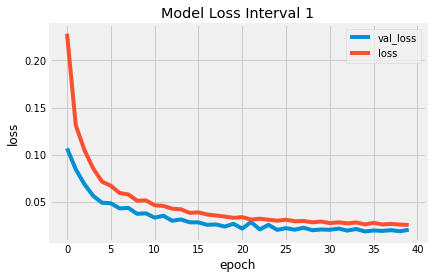

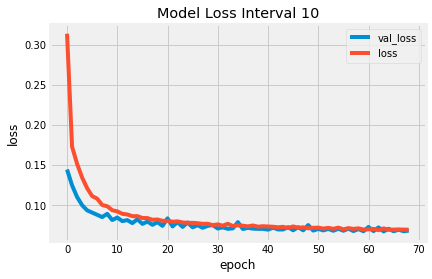

In [12]:
for i in [1,10]:
    plt.plot(model_history[i].history['val_loss'])
    plt.plot(model_history[i].history['loss'])
    plt.title('Model Loss Interval {}'.format(i))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['val_loss', 'loss'], loc='upper right')
    plt.show()

In [13]:
# Calculate Mean squared_error #
def return_mse(test,predicted):
    mse = mean_squared_error(test, predicted)
    return mse

In [14]:
# Plotting graph
def plotting_graph(y_test, y_pred, ticker, des):
    plt.plot(y_test, color='green', label='Actual adj_close value')
    plt.plot(y_pred, color='red', label='Predicted adj_close value')
    plt.title('Prediction of {} on {}'.format(ticker, des))
    plt.xlabel('Time steps')
    plt.ylabel('adj_close value')
    plt.legend()
    plt.show()

# Predict with Test Set

In [15]:
def make_test_data(s):
    scaler = {s:{}}
    test_set = {s:{}}
    test_set.update({s:{
            'x_1':{},
            'x_2':{},
            'y':{},
        }})
    for i in prediction_intervals:
            test_set[s]['x_1'][i] = []
            test_set[s]['x_2'][i] = []
            test_set[s]['y'][i] = []
            scaler[s][i] = []

    data_1 = testSet.loc[testSet['ticker'] == s][['adj_close']].values
    data_2 = testSet.loc[testSet['ticker'] == s][['volume']].values

    stop_append = {}
    for i in prediction_intervals:
        stop_append.update({i:False}) 
    l = len(data_1)
    for i in range(timesteps, l):
        x_1 = data_1[i-timesteps: i, 0]
        x_2 = data_2[i-timesteps:i, 0]
        for j in stop_append:
            if not stop_append[j]:
                if i+j-1 < l:
                    y = data_1[i+j-1,0]
                    y = y.reshape(-1,1)
                    x_1 = x_1.reshape(-1,1)
                    x_2 = x_2.reshape(-1,1)
                    
                    sc = MinMaxScaler(feature_range=(0,1))
                    sc.partial_fit(x_1)
                    sc.partial_fit(y)
                    scaler[s][j].append(sc)
                    test_set[s]['x_1'][j].append(sc.transform(x_1))
                    test_set[s]['y'][j].append(y)
                    sc = MinMaxScaler(feature_range=(0,1))
                    test_set[s]['x_2'][j].append(sc.fit_transform(x_2))
                    
                    if y == data_1[l-1,0]:
                        stop_append[j] =True
                    
    return test_set, scaler

In [17]:
def make_prediction(data, s, scaler):
    mse_val = {}
    y_true_val = {}
    y_pred_val = {}
    
    for i in prediction_intervals:
        x_test = []
        for j in range (0, len(data[s]['x_1'][i])):
            x = [
                data[s]['x_1'][i][j],
                data[s]['x_2'][i][j],
            ]
            x_test.append(x)

        X_test = np.array(x_test)
        X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])
        
        result = model[i].predict(X_test)
        y_pred = []
        for j in range(0,len(result)):
            y = result[j]
            y = y.reshape(-1,1)
            k = scaler[s][i][j].inverse_transform(y)
            y_pred.append(k[0][0])
                    
        y_test = data[s]['y'][i]
        y_true = np.array(y_test)
        y_true = y_true.reshape(y_true.shape[0])
    
        y_true_val[i] = y_true
        y_pred_val[i] = y_pred

        mse_val[i] = return_mse(y_true, y_pred) 
    return y_true_val, y_pred_val, mse_val

## Predicting test sample

In [18]:
s = 'AAPL'
data, sc = make_test_data(s)
y_true_val, y_pred_val, mse_val = make_prediction(data, s, sc)

for i in mse_val:
    print('Test Set -> MSE of {} inveral {}: {}'.format(s, i, mse_val[i]))

Test Set -> MSE of AAPL inveral 1: 9.854549839134952
Test Set -> MSE of AAPL inveral 3: 25.41569336362046
Test Set -> MSE of AAPL inveral 5: 38.43723540477498
Test Set -> MSE of AAPL inveral 10: 69.72259956682373


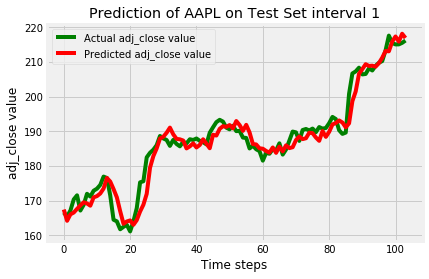

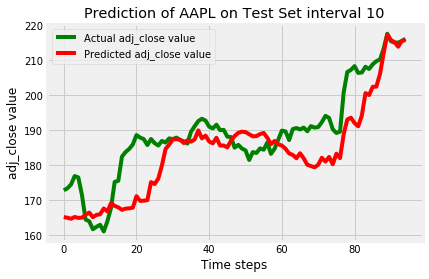

In [19]:
for i in [1,10]:
    plotting_graph(y_true_val[i], y_pred_val[i], s, 'Test Set interval {}'.format(i))

# MSE of 10 symbols

In [20]:
test_symbols = ['A', 'ACER', 'ABC', 'AAPL', 'BABA']

In [21]:
all_mse = {}
for s in test_symbols:
    all_mse[s] = {}
    data, sc = make_test_data(s)
    y_true_val, y_pred_val, mse_val = make_prediction(data, s, sc)
    for i in prediction_intervals:
        all_mse[s][i] = mse_val[i]
        all_mse[s][i] = mse_val[i]

In [24]:
all_mse_1 = []
all_mse_10 = []
for s in all_mse:
    all_mse_1.append(round(all_mse[s][1], 2))
    all_mse_10.append(round(all_mse[s][10], 2))

In [28]:
# MSE of interval 1
all_mse_1

[1.91, 1.26, 4.45, 9.85, 24.66]

In [29]:
# MSE of interval 10
all_mse_10

[3.88, 4.39, 20.43, 69.72, 93.18]

In [27]:
for i in range(0, len(all_mse_1)):
    print('MSE of Interval 10 = {} Interval 1'.format(round(all_mse_10[i]/all_mse_1[i], 1)))

MSE of Interval 10 = 2.0 Interval 1
MSE of Interval 10 = 3.5 Interval 1
MSE of Interval 10 = 4.6 Interval 1
MSE of Interval 10 = 7.1 Interval 1
MSE of Interval 10 = 3.8 Interval 1
